In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from itertools import product
from dataclasses import dataclass
from collections import namedtuple, defaultdict
from tasks.markov import *
from models.base_models import *
from models.pos_encoder import *
from tasks.test_markov import *
from config import *
from train import *
import figures.plot as plot
from util import *
import seaborn as sns
import torch.utils.benchmark as benchmark
from tqdm.notebook import tqdm, trange

from figures.head_view import *

torch.set_printoptions(precision=3, sci_mode=False)

%load_ext autoreload
%autoreload 2

In [2]:
# For comments, see TriggerMorkov.ipynb
def run_exp(SEQ_LEN, VOC_SIZE, BATCH_SIZE, 
            total_trans, alpha, pos_enc="rotary", hidden_dim=16,
            mlp_layer=None, epochs=10000, num_layers=2):

    flash = False
    
    if pos_enc in ["rotary", "abs"]:
        flash = True

    if mlp_layer is None:
        mlp_layer = num_layers - 1
        
    mlp = [False] * num_layers
    if mlp_layer < num_layers:
        mlp[mlp_layer] = True 
    mlp = tuple(mlp)
    print(mlp)
    
    config = Config(
            emb_dim=hidden_dim,
            num_layers=num_layers,
            num_heads=tuple([1]*num_layers),
            identity_query=False,
            seq_len=SEQ_LEN,
            vocab_size=VOC_SIZE,
            batch_size=BATCH_SIZE,
            num_epochs=epochs,
            eval_iter=1000,
            pos_enc=pos_enc,
            pos_max_len=SEQ_LEN,
            get_attn=500,
            get_checkpoints=1500,
            mlp=mlp,
            activation=mlp,
            flash=flash, # Use rotary
            ff_dim=hidden_dim,
            layer_norm=False,
            ngram=2,
            learning_rate=1e-4,
            task_name="latent"
        )

    sampler_config = LatentMarkovSamplerConfig(seq_len=SEQ_LEN, vocab_size=VOC_SIZE, total_trans=total_trans,
                                               batch_size=BATCH_SIZE, task_name="latent")
    
    model = Transformer(config)
    model = model.to(config.device)

    train_results = train_model_with_plot(model, config, sampler_config, show=True)

    return train_results, model

(False, True)
Max size:  4000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

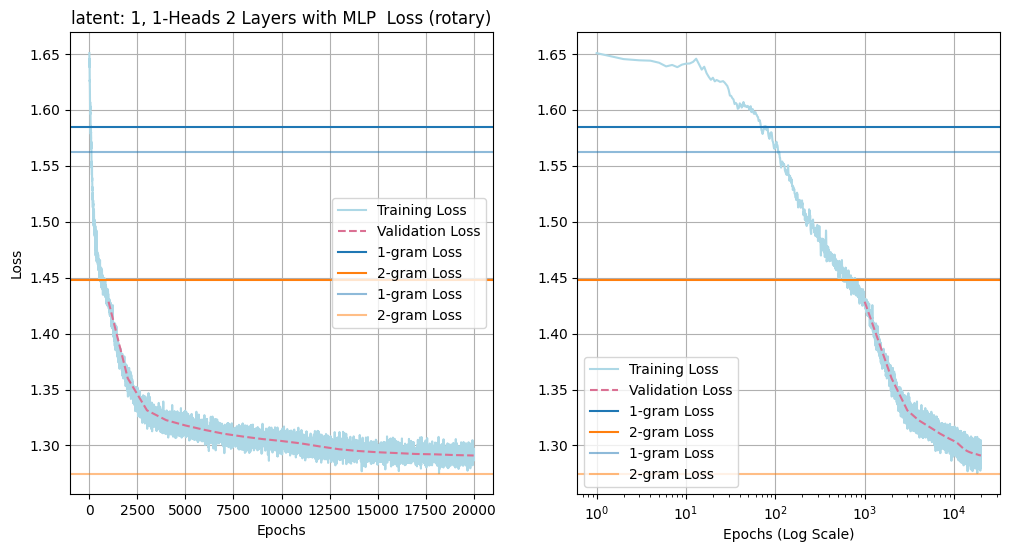

Creating images:   0%|          | 0/21 [00:00<?, ?it/s]

Creating images:   0%|          | 0/21 [00:00<?, ?it/s]

,


<IPython.core.display.Javascript object>

In [3]:
SEQ_LEN, VOC_SIZE, BATCH_SIZE = 128, 5, 64
total_trans = 2
alpha = 1
train_results, model = run_exp(SEQ_LEN, VOC_SIZE, BATCH_SIZE, total_trans, alpha, pos_enc="rotary", mlp_layer=None, epochs=20000, num_layers=2)

Let us try to understand what transformer is doing for small number of hidden latent variables. Consider 2 Markov chains, the transformer will focus on small features, such as the presence of $(2,4)$ if $(2,4)$ has very different occuring probabilities. 

Let us start with interpreting the behaviour of 1. For the first layer, 1 would attend to its own, so we have
$$
\bar{x}_t \approx x_t + W_{OV}^{(1)} x_t.
$$
For the second layer, 1 would mostly attend to 4. In the first layer, 4 has a previous token head if the previous one is not 1. So for 4, we have
$$
\bar{x}_t \approx x_t + \frac{1}{2} W_{OV}^{(1)} x_t + \frac{1}{2} W_{OV}^{(1)} x_{t-1}
$$
$$
\tilde{x}_t \approx \bar{x}_t + \sum_{s} \alpha_s W_{OV}^{(2)} \bar{x}_{s} = x_t + W_{OV}^{(1)} x_t + \text{How many (2,4) occurs}
$$

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
sampler = train_results["sampler"]
OV1 = model.layers[0].MHA.value.weight.T @ model.layers[0].MHA.out.weight.T
OV2 = model.layers[1].MHA.value.weight.T @ model.layers[1].MHA.out.weight.T
range_toks = model.embed(torch.arange(VOC_SIZE, device=device))
static_info = range_toks + range_toks @ (OV1 + OV2 + OV1@OV2)

In [15]:
batch = sampler.test()[0]
toks = model.embed(batch)
toks = model.layers[0](toks, False)[0]
tok = model.embed(torch.tensor([1]))
(toks[batch == 1] - tok - tok @ OV1).norm(dim=-1)

Latent variable:  0


tensor([0.050, 0.642, 0.693, 1.315, 1.047, 0.670, 0.650, 0.715, 0.952, 0.752,
        0.631, 0.489, 0.547, 0.779, 1.700, 1.571, 1.210, 1.250, 1.405, 1.031],
       grad_fn=<LinalgVectorNormBackward0>)

In [16]:
toks[batch == 1].norm(dim=-1)

tensor([5.030, 4.772, 4.751, 4.594, 4.646, 4.752, 4.758, 4.743, 4.681, 4.730,
        4.772, 4.833, 4.808, 4.727, 4.559, 4.548, 4.575, 4.569, 4.547, 4.619],
       grad_fn=<LinalgVectorNormBackward0>)

In [7]:
sampler.trans_matrix[0] / sampler.trans_matrix[1]

tensor([[ 2.420,  0.302,  0.893,  0.128,  2.905],
        [ 4.250,  0.307,  3.400,  0.557,  1.126],
        [16.960,  0.213,  2.007, 14.141,  0.027],
        [ 0.494,  3.921,  1.794,  1.323,  0.137],
        [ 0.170,  7.798,  0.116,  0.601,  1.997]])

In [8]:
sampler.trans_matrix[1] / sampler.trans_matrix[0]

tensor([[ 0.413,  3.308,  1.119,  7.838,  0.344],
        [ 0.235,  3.253,  0.294,  1.794,  0.888],
        [ 0.059,  4.684,  0.498,  0.071, 37.059],
        [ 2.024,  0.255,  0.557,  0.756,  7.312],
        [ 5.897,  0.128,  8.626,  1.663,  0.501]])

In [17]:
def get_attn(batch, layer, device="cpu"):
    toks = model.embed(batch)
    freqs_cis = precompute_freqs_cis(16, SEQ_LEN * 2).to(device)
    Q = model.layers[layer].MHA.query(toks).view(1, SEQ_LEN, 1, 16)
    K = model.layers[layer].MHA.key(toks).view(1, SEQ_LEN, 1, 16)
    Q, K = apply_rotary_emb(Q, K, freqs_cis=freqs_cis[:SEQ_LEN])
    Q, K = Q.transpose(1, 2), K.transpose(1, 2)
    QK = Q @ K.transpose(-1,-2) / model.layers[layer].MHA.scale
    QK = QK.masked_fill(model.layers[layer].MHA.mask==0, -float("inf"))
    A = F.softmax(QK, dim=-1)
    return A

In [160]:
mlp_out = model.layers[1].mlp(static)
probs = nn.Softmax(dim=-1)(model.output_layer(static + mlp_out))
probs

tensor([[0.083, 0.306, 0.425, 0.046, 0.139],
        [0.158, 0.245, 0.345, 0.186, 0.066],
        [0.121, 0.327, 0.260, 0.185, 0.107],
        [0.263, 0.069, 0.283, 0.304, 0.082],
        [0.043, 0.179, 0.354, 0.141, 0.282]], grad_fn=<SoftmaxBackward0>)

Latent variable:  0


<Axes: >

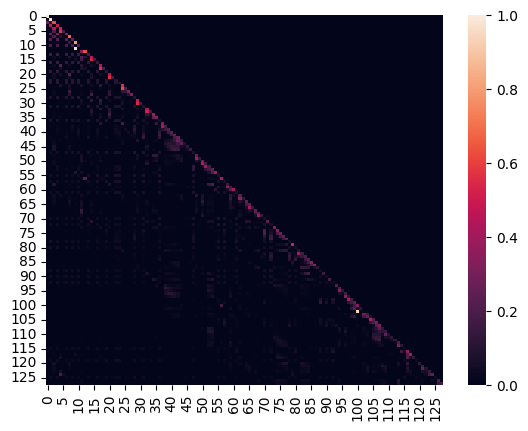

In [19]:
probe, _ = sampler.test(latent=0)
attn0 = get_attn(probe, layer = 0)
sns.heatmap(attn0.detach().numpy().squeeze(0).squeeze(0))

<Axes: >

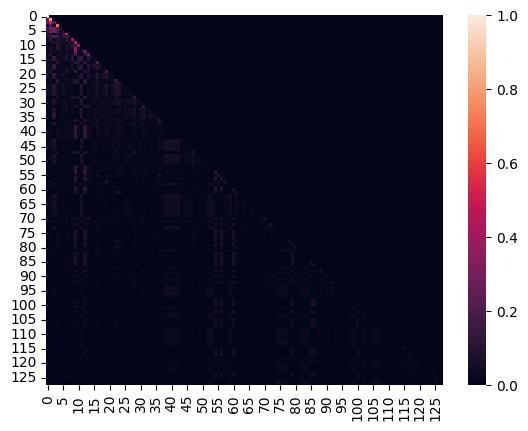

In [20]:
attn1 = get_attn(probe, layer = 1)
sns.heatmap(attn1.detach().numpy().squeeze(0).squeeze(0))

In [21]:
sampler.summary()

defaultdict(torch.Tensor,
            {0: tensor([0.205, 0.201, 0.228, 0.291, 0.075]),
             1: tensor([0.209, 0.162, 0.149, 0.268, 0.212])})

In [35]:
attn0[0][0][probe[0]==4][5]

tensor([    0.000,     0.001,     0.000,     0.001,     0.001,     0.000,
            0.002,     0.000,     0.001,     0.000,     0.001,     0.000,
            0.000,     0.002,     0.001,     0.002,     0.001,     0.002,
            0.001,     0.003,     0.005,     0.006,     0.003,     0.004,
            0.001,     0.000,     0.000,     0.001,     0.004,     0.001,
            0.000,     0.009,     0.000,     0.002,     0.008,     0.007,
            0.006,     0.003,     0.015,     0.015,     0.022,     0.024,
            0.012,     0.000,     0.000,     0.000,     0.001,     0.005,
            0.001,     0.000,     0.000,     0.000,     0.001,     0.002,
            0.015,     0.005,     0.000,     0.006,     0.003,     0.004,
            0.003,     0.004,     0.001,     0.000,     0.003,     0.013,
            0.003,     0.002,     0.000,     0.000,     0.006,     0.003,
            0.003,     0.010,     0.039,     0.033,     0.041,     0.095,
            0.003,     0.529,     0.00

<Axes: >

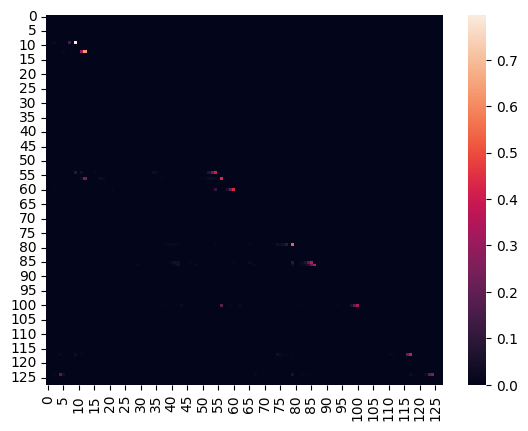

In [24]:
mask = (probe[0]!=4).unsqueeze(1).repeat(1,128)
sns.heatmap(attn0[0][0].masked_fill(mask, 0).detach().numpy())

In [277]:
attn0[0][0][probe[0]==3]

tensor([[    0.239,     0.198,     0.063,  ...,     0.000,     0.000,
             0.000],
        [    0.011,     0.045,     0.087,  ...,     0.000,     0.000,
             0.000],
        [    0.016,     0.035,     0.026,  ...,     0.000,     0.000,
             0.000],
        ...,
        [    0.000,     0.001,     0.000,  ...,     0.000,     0.000,
             0.000],
        [    0.003,     0.003,     0.000,  ...,     0.000,     0.000,
             0.000],
        [    0.001,     0.003,     0.005,  ...,     0.000,     0.000,
             0.000]], grad_fn=<IndexBackward0>)

In [246]:
get_head_view(model, train_results, train_results["config"], trunc=0, action='view', batch=probe_tensor)

<IPython.core.display.Javascript object>

In [234]:

tok = 3
F.kl_div(sampler.trans_matrix[1][tok].log(), nn.Softmax(dim=-1)(model(probe_tensor)[0])[probe==tok], reduction="none").sum(dim=-1)

tensor([    0.001,     0.000,     0.000,     0.000,     0.062,     0.047,
            0.036,     0.075,     0.149,     0.158,     0.161,     0.156,
            0.107,     0.200,     0.170,     0.177,     0.190,     0.190,
            0.189,     0.222,     0.222,     0.223,     0.238,     0.248,
            0.249,     0.249,     0.248,     0.234,     0.235,     0.224],
       grad_fn=<SumBackward1>)

In [216]:
sampler.trans_matrix[1][3]

tensor([0.261, 0.084, 0.251, 0.329, 0.075])

In [172]:
context1_avg = context1.mean(dim=0)
context0_avg = context0.mean(dim=0)

In [48]:
F.cosine_similarity(context0.unsqueeze(1), context0.unsqueeze(0), dim=-1)

tensor([[ 1.000, -0.838, -0.647,  0.783, -0.872],
        [-0.838,  1.000,  0.893, -0.888,  0.989],
        [-0.647,  0.893,  1.000, -0.907,  0.884],
        [ 0.783, -0.888, -0.907,  1.000, -0.882],
        [-0.872,  0.989,  0.884, -0.882,  1.000]], grad_fn=<SumBackward1>)

In [49]:
F.cosine_similarity(context1.unsqueeze(1), context1.unsqueeze(0), dim=-1)

tensor([[ 1.000, -0.905,  0.783,  0.956, -0.908],
        [-0.905,  1.000, -0.853, -0.953,  0.982],
        [ 0.783, -0.853,  1.000,  0.805, -0.870],
        [ 0.956, -0.953,  0.805,  1.000, -0.935],
        [-0.908,  0.982, -0.870, -0.935,  1.000]], grad_fn=<SumBackward1>)

In [54]:
mlp_out = model.layers[1].mlp(static_info)
probs = nn.Softmax(dim=-1)(model.output_layer(static_info + mlp_out)).mean(dim=0)
target = (sampler.trans_matrix[0] + sampler.trans_matrix[1]) / 2
F.kl_div(target.log(), probs, reduction="none").sum(dim=-1)

tensor([0.110, 0.053, 0.046, 0.214, 0.111], grad_fn=<SumBackward1>)

In [178]:
probs = nn.Softmax(dim=-1)(model.output_layer(static + context0_avg + model.layers[1].mlp(static + context0_avg)))
target = sampler.trans_matrix[0]
F.kl_div(target.log(), probs, reduction="none").sum(dim=-1)

tensor([0.017, 0.041, 0.005, 0.007, 0.136], grad_fn=<SumBackward1>)

In [176]:
mlp_out = model.layers[1].mlp(static + context1_avg)
probs = nn.Softmax(dim=-1)(model.output_layer(static + context1_avg + mlp_out))
target = sampler.trans_matrix[1]
F.kl_div(target.log(), probs, reduction="none").sum(dim=-1)

tensor([0.026, 0.029, 0.040, 0.001, 0.033], grad_fn=<SumBackward1>)

In [77]:
context[batch==tok][-5:].mean(dim=0).norm()

tensor(29.885, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

In [78]:
(static_info[batch==tok].mean(dim=0) + context[batch==tok][-5:].mean(dim=0)).norm()

tensor(8.415, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

In [54]:
model.output_layer(static_info)[batch==tok].mean(dim=0)

tensor([ 1.171, -2.532, -0.187,  0.118,  0.506], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [57]:
model.output_layer(static_info + model.layers[1].mlp(static_info))[batch==tok].mean(dim=0)

tensor([ 0.654,  0.464,  0.366, -0.915, -0.524], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [36]:
nn.ReLU()(static_info[batch==tok].mean(dim=0) @ model.layers[1].mlp[0].weight.T + model.layers[1].mlp[0].bias)

tensor([0.000, 3.193, 5.850, 2.812, 0.000, 0.000, 0.000, 0.463, 4.527, 0.000,
        0.000, 0.000, 1.955, 0.000, 0.258, 2.246, 0.056, 0.000, 2.499, 0.000,
        1.007, 0.569, 4.376, 0.000, 2.014, 0.582, 0.000, 0.000, 0.000, 2.687,
        3.812, 2.058], device='cuda:0', grad_fn=<ReluBackward0>)

In [38]:
# latent 0
nn.ReLU()((context_tok + static_info[batch==tok].mean(dim=0)) @ model.layers[1].mlp[0].weight.T + model.layers[1].mlp[0].bias)

tensor([0.091, 3.599, 6.372, 3.893, 0.000, 0.000, 0.000, 0.000, 6.385, 0.000,
        0.000, 0.000, 1.325, 0.000, 0.000, 3.501, 0.000, 0.000, 3.296, 0.000,
        0.391, 0.000, 5.277, 0.000, 2.100, 1.794, 0.000, 0.000, 0.000, 4.170,
        5.574, 0.000], device='cuda:0', grad_fn=<ReluBackward0>)

In [52]:
# latent 1
nn.ReLU()((context_tok + static_info[batch==tok].mean(dim=0)) @ model.layers[1].mlp[0].weight.T + model.layers[1].mlp[0].bias)

tensor([0.000, 1.984, 0.000, 1.822, 0.000, 3.143, 4.114, 2.869, 0.000, 0.000,
        3.853, 3.414, 0.493, 0.000, 0.000, 0.000, 1.111, 0.558, 0.124, 4.741,
        3.380, 0.000, 0.000, 0.000, 1.888, 0.000, 2.387, 0.000, 1.388, 0.000,
        0.000, 2.951], device='cuda:0', grad_fn=<ReluBackward0>)

In [83]:
batch, _ = sampler.modified(0, 1, 0)

Latent variable:  0


In [84]:
nn.Softmax(dim=-1)(model(batch)[0])[batch==0]

tensor([[0.204, 0.153, 0.349, 0.142, 0.152],
        [0.219, 0.135, 0.351, 0.131, 0.164],
        [0.179, 0.174, 0.334, 0.168, 0.144],
        [0.200, 0.160, 0.339, 0.152, 0.150],
        [0.196, 0.167, 0.333, 0.157, 0.147],
        [0.086, 0.271, 0.296, 0.246, 0.100],
        [0.130, 0.220, 0.324, 0.206, 0.120],
        [0.098, 0.257, 0.307, 0.231, 0.107],
        [0.068, 0.289, 0.278, 0.271, 0.094],
        [0.068, 0.291, 0.286, 0.257, 0.098],
        [0.062, 0.293, 0.282, 0.267, 0.096],
        [0.058, 0.301, 0.277, 0.268, 0.096],
        [0.056, 0.296, 0.291, 0.260, 0.096],
        [0.067, 0.290, 0.300, 0.246, 0.098]], device='cuda:0',
       grad_fn=<IndexBackward0>)

In [85]:
sampler.trans_matrix

tensor([[[0.065, 0.300, 0.271, 0.277, 0.087],
         [0.021, 0.272, 0.080, 0.401, 0.225],
         [0.157, 0.070, 0.106, 0.233, 0.433],
         [0.155, 0.107, 0.324, 0.280, 0.134],
         [0.137, 0.158, 0.385, 0.089, 0.230]],

        [[0.235, 0.130, 0.340, 0.126, 0.170],
         [0.109, 0.182, 0.158, 0.541, 0.010],
         [0.094, 0.103, 0.455, 0.121, 0.227],
         [0.054, 0.433, 0.124, 0.317, 0.072],
         [0.082, 0.092, 0.502, 0.074, 0.251]],

        [[0.026, 0.257, 0.021, 0.384, 0.312],
         [0.168, 0.053, 0.105, 0.621, 0.053],
         [0.016, 0.010, 0.588, 0.062, 0.324],
         [0.109, 0.167, 0.276, 0.353, 0.094],
         [0.100, 0.025, 0.243, 0.607, 0.025]]], device='cuda:0')

In [77]:
tok = 0
context_tok = context[batch==tok][-5:].mean(dim=0)
probs = nn.Softmax(dim=-1)(model.output_layer(static_info + context_tok + model.layers[1].mlp(static_info+context_tok)))[batch==tok].mean(dim=0)
target = sampler.trans_matrix[0][tok]
F.kl_div(target.log(), probs, reduction="sum")

tensor(0.002, device='cuda:0', grad_fn=<SumBackward0>)

In [58]:
tok = 4
context_other = context[batch==2][-5:].mean(dim=0)
probs = nn.Softmax(dim=-1)(model.output_layer(static_info + context_other + model.layers[1].mlp(static_info + context_other)))[batch==tok].mean(dim=0)
target = sampler.trans_matrix[0][tok]
F.kl_div(target.log(), probs, reduction="sum")

tensor(0.157, device='cuda:0', grad_fn=<SumBackward0>)

In [48]:
F.kl_div(sampler.trans_matrix[0][0].log(), nn.Softmax(dim=-1)(model(batch)[0])[batch==0], reduction="none").sum(dim=-1)

tensor([0.055, 0.003, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002, 0.001, 0.003,
        0.003, 0.003, 0.002, 0.002], device='cuda:0', grad_fn=<SumBackward1>)

In [51]:
tok = 3
F.kl_div(sampler.trans_matrix[0][tok].log(), nn.Softmax(dim=-1)(model(batch)[0])[batch==tok], reduction="none").sum(dim=-1)

tensor([0.018, 0.016, 0.014, 0.001, 0.002, 0.001, 0.001, 0.004, 0.002, 0.002,
        0.002, 0.003, 0.001, 0.001, 0.003, 0.002, 0.002, 0.002, 0.002, 0.004,
        0.002, 0.002, 0.002, 0.002, 0.002, 0.003, 0.002, 0.002, 0.002],
       device='cuda:0', grad_fn=<SumBackward1>)

In [67]:
nn.Softmax(dim=-1)(model.output_layer(toks2+toks1 + model.layers[1].mlp(toks1 + toks2)))[batch == 1]

tensor([[0.369, 0.085, 0.108, 0.188, 0.250],
        [0.373, 0.080, 0.112, 0.185, 0.250],
        [0.380, 0.084, 0.110, 0.181, 0.246],
        [0.377, 0.082, 0.108, 0.180, 0.253],
        [0.375, 0.082, 0.111, 0.186, 0.247],
        [0.376, 0.083, 0.108, 0.184, 0.250],
        [0.375, 0.081, 0.110, 0.186, 0.247],
        [0.373, 0.082, 0.108, 0.185, 0.252],
        [0.374, 0.081, 0.111, 0.186, 0.248],
        [0.373, 0.083, 0.107, 0.185, 0.252],
        [0.368, 0.078, 0.111, 0.186, 0.258],
        [0.371, 0.083, 0.108, 0.185, 0.253],
        [0.373, 0.084, 0.107, 0.184, 0.252],
        [0.369, 0.080, 0.109, 0.184, 0.258],
        [0.372, 0.082, 0.110, 0.186, 0.250],
        [0.373, 0.079, 0.110, 0.182, 0.257],
        [0.373, 0.082, 0.107, 0.184, 0.254],
        [0.373, 0.082, 0.107, 0.184, 0.254],
        [0.374, 0.082, 0.106, 0.184, 0.254],
        [0.374, 0.080, 0.109, 0.181, 0.256],
        [0.373, 0.079, 0.109, 0.181, 0.257],
        [0.385, 0.082, 0.102, 0.179, 0.253],
        [0

In [230]:
OV_2 = model.layers[1].MHA.value.weight.T @ model.layers[1].MHA.out.weight.T
range_toks = torch.arange(VOC_SIZE)
toks = model.embed(range_toks)
toks @ OV_2 @ model.output_layer.weight.T

tensor([[    -0.143,      0.211,     -1.574,      1.501,     -0.153,      0.371,
             -1.002,      0.245,     -2.099,      0.211],
        [    -0.483,     -0.131,     -0.712,      0.938,     -0.559,      0.263,
             -0.664,      0.135,     -1.029,      0.262],
        [     0.320,      0.328,     -0.718,     -0.371,      0.575,     -0.193,
              0.590,      0.120,      0.341,     -0.794],
        [     0.177,      0.512,     -1.156,      0.781,      0.334,      0.082,
             -0.295,     -0.029,     -1.034,     -0.393],
        [     0.501,     -2.059,      7.036,     -7.117,     -2.408,     -1.739,
              4.708,     -0.300,     10.424,      1.103],
        [     0.578,     -1.332,      5.385,     -5.406,     -1.666,     -1.336,
              3.919,     -0.344,      8.064,      0.662],
        [    -0.192,      1.318,     -4.612,      4.412,      1.263,      0.853,
             -2.934,      0.441,     -6.396,     -0.460],
        [     1.052,     -0

In [227]:
OV_1 = model.layers[0].MHA.value.weight.T @ model.layers[0].MHA.out.weight.T
torch.norm(OV_1, dim=-1)

tensor([0.344, 0.465, 0.363, 0.323, 0.351, 0.439, 0.350, 0.446, 0.350, 0.341,
        0.427, 0.315, 0.399, 0.335, 0.368, 0.393, 0.375, 0.377, 0.410, 0.417,
        0.318, 0.364, 0.336, 0.288, 0.310, 0.355, 0.431, 0.366, 0.409, 0.371,
        0.449, 0.394, 0.427, 0.389, 0.318, 0.368, 0.327, 0.378, 0.381, 0.354,
        0.346, 0.367, 0.357, 0.301, 0.395, 0.374, 0.379, 0.287, 0.460, 0.298,
        0.335, 0.382, 0.440, 0.438, 0.340, 0.355, 0.411, 0.384, 0.377, 0.325,
        0.425, 0.368, 0.381, 0.358, 0.369, 0.413, 0.383, 0.343, 0.365, 0.366,
        0.381, 0.349, 0.359, 0.298, 0.374, 0.424, 0.369, 0.365, 0.294, 0.349,
        0.322, 0.401, 0.464, 0.343, 0.363, 0.356, 0.367, 0.332, 0.388, 0.336,
        0.363, 0.345, 0.371, 0.376, 0.349, 0.377, 0.310, 0.315, 0.370, 0.410,
        0.402, 0.410, 0.473, 0.354, 0.390, 0.392, 0.369, 0.348, 0.390, 0.348,
        0.420, 0.377, 0.390, 0.326, 0.380, 0.401, 0.346, 0.347, 0.438, 0.337,
        0.334, 0.371, 0.367, 0.322, 0.401, 0.328, 0.384, 0.410],

In [6]:
sampler = train_results["sampler"]

In [6]:
batch, prob = sampler.test()

Latent variable:  0


In [57]:
batch

tensor([[3, 3, 5, 1, 5, 3, 2, 3, 3, 2, 3, 6, 8, 2, 4, 6, 3, 4, 0, 2, 7, 5, 1, 3,
         4, 0, 9, 3, 2, 4, 7, 8, 2, 5, 5, 8, 8, 8, 7, 0, 8, 0, 9, 1, 7, 8, 4, 0,
         7, 4, 4, 4, 0, 9, 7, 2, 2, 2, 7, 0, 9, 7, 8, 0, 0, 0, 1, 3, 6, 0, 3, 6,
         9, 9, 7, 8, 0, 7, 0, 6, 8, 9, 7, 4, 6, 5, 6, 9, 4, 6, 5, 1, 9, 6, 5, 9,
         2, 4, 8, 2, 7, 6, 5, 9, 7, 2, 4, 0, 1, 3, 0, 6, 0, 6, 4, 9, 7, 2, 5, 0,
         1, 2, 3, 8, 2, 0, 0, 7]])

In [216]:
tok1 = 6
tok2 = 8
# (6,8) appears much more often in 0 than 1
probe = torch.tensor([[tok1, tok2]*(SEQ_LEN//2)])
tok = 9
probe[0,60] = tok
logits = model(probe)[0][0]

In [217]:
(nn.Softmax(dim=1)(logits)[probe[0]==tok] - sampler.trans_matrix[0][tok].unsqueeze(0)).abs().sum(dim=-1).detach()

tensor([0.212])

In [218]:
(nn.Softmax(dim=1)(logits)[probe[0]==tok] - sampler.trans_matrix[1][tok].unsqueeze(0)).abs().sum(dim=-1).detach()

tensor([0.815])

In [173]:
sampler.trans_matrix[1][tok, tok2], sampler.trans_matrix[1][tok2, tok]

(tensor(0.170), tensor(0.083))

In [174]:
sampler.trans_matrix[0][tok, tok2], sampler.trans_matrix[0][tok2, tok]

(tensor(0.009), tensor(0.422))

In [7]:
ratio10 = (sampler.trans_matrix[1] / sampler.trans_matrix[0])
ratio01 = (sampler.trans_matrix[0] / sampler.trans_matrix[1])

In [18]:
ratio10[4,3], ratio01[4,3]

(tensor(0.625, device='cuda:0'), tensor(1.599, device='cuda:0'))

In [3]:
with open('checkpoints/latent/20250225_0018/train_results.pkl', 'rb') as file:
    train_results = pickle.load(file)
config = train_results["config"]
model_ckpt = Transformer(config)
checkpoint = torch.load("checkpoints/bietti/20250221_0018/model_79500.pt", weights_only=True)
model_ckpt.load_state_dict(checkpoint)
model_ckpt = model_ckpt.to("cpu")

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.